# Simple Example

## Introduction

In this example, we present an existing method [1] and our new method on a very simple simulated dataset. <br>
We compare both methods based on simplicity, goodness of fit and performance. <br>
<br>
[1] On the Analysis of Discrete Time Competing Risks Data, Biometrics, Lee et al. 2018

## Data Generation

We simulate N=10,000 patients, with 5 covariate $Z_p$ ($p \in [1,...,5]$) randomly sampled from $\mathbb{R} [0,1]$. <br> <br>
Our timeline is discrete, i.e $t \in \mathbb{Z} [1,...,d]$. Here, we choose $d=30$. <br> <br>
The event type $J_i$ is randomly sampled from $J_i \sim Uniform[1,...,M]$, where $M$ is the number of competing events. In this example $M=2$. <br><br>
For each of the samples, we sample it's time-to-event $T_i$ from the hazard function $\lambda_{j}(T|Z) = \frac{exp(\alpha_{jt}+Z^{T}\beta_{j})}{1+exp(\alpha_{jt}+Z^{T}\beta_{j})}$ such that <br>
$\alpha_{1t} = -3-0.3 log(t)$ <br> 
$\beta_{1} = -log([2, 3, 6, 5, 5])$ <br> 
$\alpha_{2t} = -1-0.6 log(t)$ <br> 
$\beta_{2} = -log([1, 3, 5, 3, 2])$ <br> 

and randomly sample a censoring time $C_i$ such that $C_i \sim Uniform[1, ... , d]$. <br>
We then calculate $X_i = min(T_i, C_i)$ and for cencored samples we set the event type to be $J=0$. <br><br>
Lastly, we split the data into two separate datasets for training (75%) and for testing (25%).

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from pydts.utils import get_expanded_df
from tqdm import tqdm
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lifelines.fitters.coxph_fitter import CoxPHFitter
from scipy.special import expit
from scipy.optimize import minimize
import sys
sys.path.append('../')
sys.path.append('../../')
from examples.generate_simulations_data import generate_quick_start_df
import warnings
warnings.filterwarnings('ignore')

In [2]:
n_cov = 5
patients_df = generate_quick_start_df(n_patients=50000, n_cov=n_cov, d_times=30, j_events=2, pid_col='pid', 
                                      seed=0)
covariates = [f'Z{i + 1}' for i in range(n_cov)]

train_df, test_df = train_test_split(patients_df, test_size=0.25)
events = sorted(train_df['J'].unique())
times = sorted(train_df['X'].unique())
train_df.head()  

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X
9984,9984,0.773365,0.820337,0.215116,0.063890,0.505526,0,5,1,1
10757,10757,0.376063,0.797547,0.368938,0.256831,0.110968,0,21,12,12
44665,44665,0.611291,0.228386,0.297380,0.171173,0.415985,0,16,7,7
38420,38420,0.125325,0.567222,0.523307,0.498498,0.969743,0,30,11,11
36208,36208,0.598941,0.833422,0.296596,0.624476,0.456126,0,27,13,13


## Lee et al. 2018 [1]

Lee et al. suggested to expand the data so that for each patient we have row for each $t \in [1, T_i]$, with binary event columns which are 1 only at the time of the event. here $j_0 = 1 - j_1 - j_2$. <br> <br>
Then, for each event we estimate {$\alpha_{jt}, \beta_{j}$} using a binary regression model.

In [3]:
expanded_train_df = get_expanded_df(train_df)
print(expanded_train_df.shape)
expanded_train_df

(338826, 13)


,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X,j_0,j_1,j_2
0,9984,0.773365,0.820337,0.215116,0.063890,0.505526,0,5,1,1,1.0,0.0,0.0
1,10757,0.376063,0.797547,0.368938,0.256831,0.110968,0,21,12,1,1.0,0.0,0.0
2,10757,0.376063,0.797547,0.368938,0.256831,0.110968,0,21,12,2,1.0,0.0,0.0
3,10757,0.376063,0.797547,0.368938,0.256831,0.110968,0,21,12,3,1.0,0.0,0.0
4,10757,0.376063,0.797547,0.368938,0.256831,0.110968,0,21,12,4,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338821,7370,0.415688,0.750578,0.161823,0.459782,0.246380,1,13,18,9,1.0,0.0,0.0
338822,7370,0.415688,0.750578,0.161823,0.459782,0.246380,1,13,18,10,1.0,0.0,0.0
338823,7370,0.415688,0.750578,0.161823,0.459782,0.246380,1,13,18,11,1.0,0.0,0.0
338824,7370,0.415688,0.750578,0.161823,0.459782,0.246380,1,13,18,12,1.0,0.0,0.0


In [4]:
expanded_train_df = pd.concat([expanded_train_df, 
                               pd.get_dummies(expanded_train_df['X'], prefix='alpha')], axis=1)
expanded_train_df

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X,...,alpha_21,alpha_22,alpha_23,alpha_24,alpha_25,alpha_26,alpha_27,alpha_28,alpha_29,alpha_30
0,9984,0.773365,0.820337,0.215116,0.063890,0.505526,0,5,1,1,...,0,0,0,0,0,0,0,0,0,0
1,10757,0.376063,0.797547,0.368938,0.256831,0.110968,0,21,12,1,...,0,0,0,0,0,0,0,0,0,0
2,10757,0.376063,0.797547,0.368938,0.256831,0.110968,0,21,12,2,...,0,0,0,0,0,0,0,0,0,0
3,10757,0.376063,0.797547,0.368938,0.256831,0.110968,0,21,12,3,...,0,0,0,0,0,0,0,0,0,0
4,10757,0.376063,0.797547,0.368938,0.256831,0.110968,0,21,12,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338821,7370,0.415688,0.750578,0.161823,0.459782,0.246380,1,13,18,9,...,0,0,0,0,0,0,0,0,0,0
338822,7370,0.415688,0.750578,0.161823,0.459782,0.246380,1,13,18,10,...,0,0,0,0,0,0,0,0,0,0
338823,7370,0.415688,0.750578,0.161823,0.459782,0.246380,1,13,18,11,...,0,0,0,0,0,0,0,0,0,0
338824,7370,0.415688,0.750578,0.161823,0.459782,0.246380,1,13,18,12,...,0,0,0,0,0,0,0,0,0,0


In [5]:
alpha_list = [col for col in expanded_train_df.columns if col[:5] == 'alpha']
models = {}

In [6]:
start = time()

for e in tqdm(events[1:], total=len(events)-1):
    model = LogisticRegression()
    X, y =  expanded_train_df[covariates + alpha_list].values, expanded_train_df[f'j_{e}'].values
    model.fit(X, y)
    models[e] = model

end = time()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.49s/it]


In [7]:
print(f'Total training time: {end - start:.2f} seconds')

Total training time: 12.99 seconds


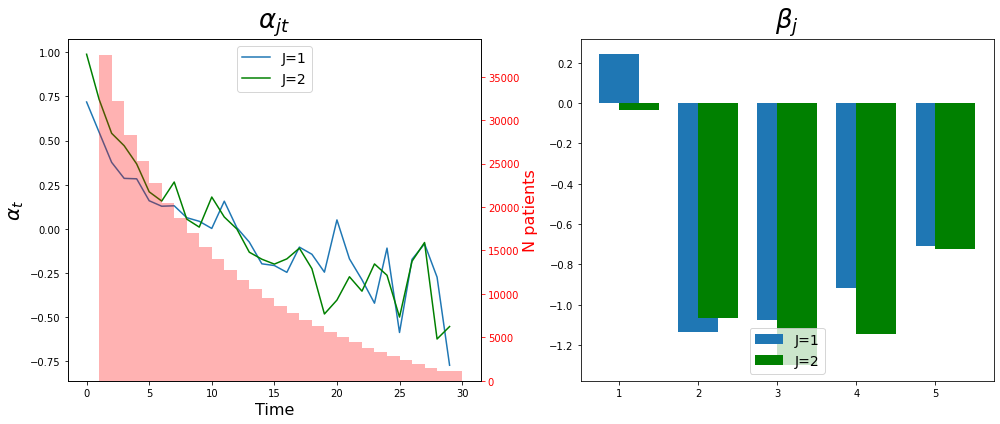

In [8]:
fig, axes = plt.subplots(1,2, figsize=(14,6))
ax = axes[0]
ax.set_title(r'$\alpha_{jt}$', fontsize=26)
ax.plot(models[1].coef_[0, n_cov:], label='J=1')
ax.plot(models[2].coef_[0, n_cov:], color='g', label='J=2')
ax.set_xlabel(r'Time', fontsize=16)
ax.set_ylabel(r'$\alpha_{t}$', fontsize=20)
ax.legend(loc='upper center', fontsize=14)
ax2 = ax.twinx()
ax2.hist(expanded_train_df['X'], color='r', alpha=0.3, bins=times)
ax2.set_ylabel('N patients', fontsize=16, color='red')
ax2.tick_params(axis='y', colors='red')

ax = axes[1]
ax.set_title(r'$\beta_{j}$', fontsize=26)
ax.bar(np.arange(1, n_cov+1), models[1].coef_[0, :n_cov], label='J=1', width=0.5)
ax.bar(np.arange(1, n_cov+1), models[2].coef_[0, :n_cov], color='g', label='J=2', align='edge', width=0.5)
ax.legend(loc='lower center', fontsize=14)

fig.tight_layout()

In [9]:
# test mse

## New approach

Here, for each event, we first estimate $\beta_{j}$ using a time-stratified CoxPH model and the expanded data as we used in the previous approach. <br> <br>
Afterwards, we evaluate $\alpha_{jt}$ based on the original training data.

In [10]:
beta_models = {}

for e in events[1:]:
    strata_df = expanded_train_df[covariates + [f'j_{e}', 'X']].copy()
    strata_df['X_copy'] = expanded_train_df['X']

    beta_j_cox = CoxPHFitter()
    beta_j_cox.fit(df=strata_df[covariates+ ['X', 'X_copy', f'j_{e}']], duration_col='X', event_col=f'j_{e}', 
                   strata='X_copy')
    beta_models[e] = beta_j_cox
    #print(beta_j_cox.params_)

Going back to the unexpanded data: 

In [11]:
train_df.head()

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X
9984,9984,0.773365,0.820337,0.215116,0.063890,0.505526,0,5,1,1
10757,10757,0.376063,0.797547,0.368938,0.256831,0.110968,0,21,12,12
44665,44665,0.611291,0.228386,0.297380,0.171173,0.415985,0,16,7,7
38420,38420,0.125325,0.567222,0.523307,0.498498,0.969743,0,30,11,11
36208,36208,0.598941,0.833422,0.296596,0.624476,0.456126,0,27,13,13


In [12]:
y_t = len(train_df['X']) - train_df['X'].value_counts().sort_index().cumsum()
y_t.head()

1    32156
2    28280
3    25275
4    22732
5    20515
Name: X, dtype: int64

In [13]:
n_jt = train_df.groupby(['J', 'X']).size().to_frame().reset_index()
n_jt.columns = ['J', 'X' ,'n_jt']
n_jt.head()

,J,X,n_jt
0,0,1,1115
1,0,2,1004
2,0,3,937
3,0,4,875
4,0,5,810


In [14]:
def alpha_jt(x, df, y_t, beta_j, n_jt, t, duration_col='X' ):
    partial_df = df[df[duration_col] >= t]
    expit_add = (partial_df[covariates]*beta_j).sum(axis=1)
    return ((1/y_t)*np.sum(expit(x+expit_add)) - (n_jt/y_t))**2

In [15]:
x0 = 0
alpha_df = pd.DataFrame()
for e in events[1:]:
    n_et = n_jt[n_jt['J'] == e]
    n_et['opt_res'] = n_et.apply(lambda row: minimize(alpha_jt, x0, 
        args=(train_df, y_t.loc[row['X']], beta_models[e].params_,  row['n_jt'],  row['X'])), axis=1)
    n_et['success'] = n_et['opt_res'].apply(lambda val: val.success)
    n_et['alpha_jt'] = n_et['opt_res'].apply(lambda val: val.x[0])
    alpha_df = alpha_df.append(n_et, ignore_index=True)
alpha_df.head(10)

,J,X,n_jt,opt_res,success,alpha_jt
0,1,1,2418,"{'fun': 7.380332988113922e-11, 'jac': [1.18589...",True,-1.051440
1,1,2,1703,"{'fun': 5.334490043277141e-09, 'jac': [8.21030...",True,-1.222452
2,1,3,1240,"{'fun': 2.5521013341282933e-10, 'jac': [1.4799...",True,-1.394261
3,1,4,994,"{'fun': 2.0162886351545604e-09, 'jac': [3.7327...",True,-1.484891
4,1,5,872,"{'fun': 3.025892052876233e-09, 'jac': [4.45298...",True,-1.487855
5,1,6,685,"{'fun': 4.144096951693311e-11, 'jac': [4.52112...",True,-1.613652
6,1,7,594,"{'fun': 1.0266706439218201e-10, 'jac': [6.8094...",True,-1.645349
7,1,8,534,"{'fun': 1.1697906415906709e-10, 'jac': [7.2081...",True,-1.642677
8,1,9,446,"{'fun': 5.617667690996546e-10, 'jac': [1.45129...",True,-1.710620
9,1,10,393,"{'fun': 9.410622434272904e-10, 'jac': [1.81975...",True,-1.731172


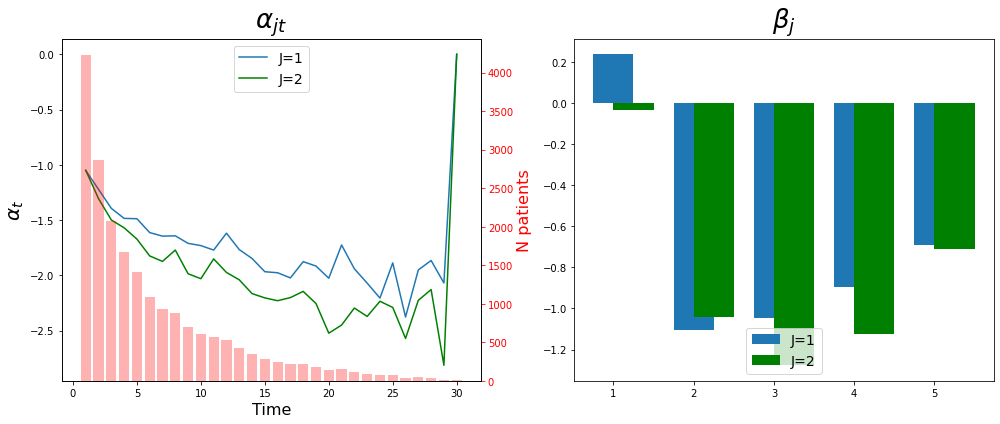

In [16]:
fig, axes = plt.subplots(1,2, figsize=(14,6))
ax = axes[0]
ax.set_title(r'$\alpha_{jt}$', fontsize=26)
tmp_ajt = alpha_df[alpha_df['J'] == 1]
ax.plot(tmp_ajt['X'].values, tmp_ajt['alpha_jt'].values, label='J=1')
tmp_ajt = alpha_df[alpha_df['J'] == 2]
ax.plot(tmp_ajt['X'].values, tmp_ajt['alpha_jt'].values, color='g', label='J=2')
ax.set_xlabel(r'Time', fontsize=16)
ax.set_ylabel(r'$\alpha_{t}$', fontsize=20)
ax.legend(loc='upper center', fontsize=14)
ax2 = ax.twinx()
ax2.bar(alpha_df.groupby('X')['n_jt'].sum().index, alpha_df.groupby('X')['n_jt'].sum().values, color='r', alpha=0.3)
ax2.set_ylabel('N patients', fontsize=16, color='red')
ax2.tick_params(axis='y', colors='red')

ax = axes[1]
ax.set_title(r'$\beta_{j}$', fontsize=26)
ax.bar(np.arange(1, n_cov+1), beta_models[1].params_.values, label='J=1', width=0.5)
ax.bar(np.arange(1, n_cov+1), beta_models[2].params_.values, color='g', label='J=2', align='edge', width=0.5)
ax.legend(loc='lower center', fontsize=14)

fig.tight_layout()

## Comparison (WIP)

In [17]:
pd.DataFrame(index=['N=1000', 'N=10000', 'N=100000'], columns=['Train MSE (oracle)', 'Test MSE (oracle)', 'computation time'])

,Train MSE (oracle),Test MSE (oracle),computation time
N=1000,NaN,NaN,NaN
N=10000,NaN,NaN,NaN
N=100000,NaN,NaN,NaN
